In [49]:
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import string
import sys
import os 
import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import seaborn as sns
from Utils import *

In [2]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

Last updated: 2024-07-27 20:05:10CEST

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

sklearn: 1.5.1

scipy        : 1.14.0
black        : 24.4.2
numpy        : 2.0.1
sklearn      : 1.5.1
pandas       : 2.2.2
jupyter_black: 0.3.4
matplotlib   : 3.9.1
sys          : 3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]

Watermark: 2.4.3



In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [4]:
plt.style.use("../matplotlib_style.txt")

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [6]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [8]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [10]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [11]:
cluster_colors.shape
print(len(np.unique(cluster_colors)))

78


In [12]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [13]:
ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

print(rna_type.shape)
print(rna_type)

(1329,)
['L5 ET_1' 'L5 IT_2' 'L5 IT_1' ... 'L5 ET_1' nan 'Pvalb Gpr149']


In [14]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [15]:
print(dict_rna_type_colors)
rna_type_colors_array = np.array(list(dict_rna_type_colors.values()))
print(len(rna_type_colors_array))
print(len(np.unique(rna_type_colors_array)))

{'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98', 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963', 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3', 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF', 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_1': '#F70CF3', 'Vip Chat_1': '#FF00FF', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00', 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09', 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652', 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Ca

### Electrophysiological features

In [16]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [17]:
ephys_pd = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

# print(ephys_pd["cell id"])
# print(ephys_pd.head())
# print(cells)

gene_data = pd.read_csv(data_path / "gene_lengths.txt")
print(gene_data.head())

          GeneID  exon_bp  intron_bp  gene_bp
0  0610005C13Rik     3583       3951     7534
1  0610006L08Rik     2128      32868    34996
2  0610009B22Rik      998       2491     3489
3  0610009E02Rik     1803      11892    13695
4  0610009L18Rik      619       1894     2513


In [18]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData

print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [19]:
ephysData_filtered

array([[ 0.98608392,  0.64834158, -0.93881053, ...,  3.04737527,
         0.16776081,  0.63710672],
       [ 0.58728941,  0.45548548, -0.80161871, ...,  2.96590616,
        -0.76260223,  0.99778569],
       [ 0.36748484,  0.036109  , -0.11310118, ...,  3.04737527,
        -0.31069552,  1.05910185],
       ...,
       [ 0.66987131, -0.0487444 , -0.34647255, ...,  4.75822642,
         0.21211713,  0.73777371],
       [ 0.41921208,  0.55079968, -0.32063559, ...,  3.61765898,
         0.10267565,  1.50108896],
       [-0.50165036, -0.14969752, -0.01064697, ...,  0.76624039,
        -1.16822945, -1.10823434]])

In [20]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

In [21]:
print(cluster_colors[keepcells].shape)
print(cluster_colors[keepcells][0:5])
for i in range(0, 5):
    print(cluster_colors[keepcells][i])
    for key, value in dict_rna_type_colors.items():
        if value == cluster_colors[keepcells][i]:
            print(key)

(1320,)
['#0D5D7E' '#4A9F93' '#58D2C1' '#0A75B1' '#0D5D7E']
#0D5D7E
L5 ET_1
#4A9F93
L5 IT_2
#58D2C1
L5 IT_1
#0A75B1
L5 ET_4
#0D5D7E
L5 ET_1


# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.

### Compile the cell types pandas dataframe (Artemii)

In [23]:
import json

# Convert rna_type to a Pandas Series if it is not already
rna_type = pd.Series(rna_type) if not isinstance(rna_type, pd.Series) else rna_type

# Remove NaNs from rna_type and count occurrences of each RNA type
rna_type_clean = rna_type.dropna()
rna_type_counts = rna_type_clean.value_counts().to_dict()

# Add a 'Not identified' key if there were NaNs in the original rna_type array
if rna_type.isnull().sum() > 0:
    rna_type_counts["Not identified"] = rna_type.isnull().sum()

# Sort the dictionary by keys
rna_type_counts = dict(sorted(rna_type_counts.items()))
# Move 'Not identified' to the end if it exists
if "Not identified" in rna_type_counts:
    rna_type_counts["Not identified"] = rna_type_counts.pop("Not identified")

# Create a DataFrame for cell types and their colors
cell_types = list(rna_type_counts.keys())
mapping_db = pd.DataFrame({"cell_types": cell_types})

# Assign colors to cell types
mapping_db["color"] = mapping_db["cell_types"].apply(
    lambda cell_type: dict_rna_type_colors.get(cell_type, "gray")
)

# Define marker lists based on the paper
excitatory_markers = [
    "L2/3 IT",
    "L4/5 IT",
    "L5 IT",
    "L6 IT",
    "L6b",
    "L6",
    "L5/6",
    "L5",
    "L6",
    "L2/3",
    "L4",
    "L5 IT",
    "L6 IT",
    "L6 CT",
    "L6b",
    "L6 CT",
]
cge_markers = ["Lamp5", "Sncg", "Vip"]
mge_markers = ["Sst", "Pvalb"]


# Assign types to cell types based on markers
def assign_type(cell_type):
    if any(marker in cell_type for marker in excitatory_markers):
        return "Excitatory neurons"
    if any(marker in cell_type for marker in cge_markers):
        return "CGE-derived interneurons"
    if any(marker in cell_type for marker in mge_markers):
        return "MGE-derived interneurons"
    return None


mapping_db["type"] = mapping_db["cell_types"].apply(assign_type)

# Add counts to the DataFrame
mapping_db["count"] = mapping_db["cell_types"].map(rna_type_counts)

# Sort the DataFrame by type and cell types
mapping_db = mapping_db.sort_values(by=["type", "cell_types"])

# Define groups
neuron_groups = [
    "Excitatory neurons",
    "CGE-derived interneurons",
    "MGE-derived interneurons",
]

#### Plotting function for cell types and classes

In [ ]:
def plot_cell_types(groups: list, ax: plt.Axes, base_font_size: int = 8) -> None:
    """
    Plot cell types of the mapping database

    Parameters
    ----------

    groups: list
        List of groups to plot

    ax: plt.Axes
        Axis to plot on

    base_font_size: int
        Base font size for plotting

    Return
    ------
    None

    """
    global mapping_db
    x_base = 0
    xticks = []
    xticklabels = []

    max_height = max(mapping_db["count"])
    figsize = ax.get_figure().get_size_inches()
    width_factor = figsize[0] / 15
    height_factor = figsize[1] / 5
    font_size = calculate_font_size(base_font_size, min(width_factor, height_factor))

    for i, group in enumerate(groups):
        group_data = mapping_db[mapping_db["type"] == group]
        x_positions = np.arange(len(group_data)) + x_base

        ax.bar(x_positions, group_data["count"], color=group_data["color"], width=0.8)

        ax.text(
            x_base + (len(group_data) - 1) / 2,
            max_height - 10,
            group,
            ha="center",
            va="bottom",
            fontsize=font_size * 1.2,
            fontweight="bold",
        )

        xticks.extend(x_positions)
        xticklabels.extend(group_data["cell_types"])

        x_base += len(group_data) + 1  # Increment x_base for next group

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=font_size)

    ax.set_ylabel("Count")

## Analisys of ePhys Data (Artemii)

### Dimensionality reduction and plotting 

#### PCA

In [24]:
# perform PCA on the filtered ephys data
pca = PCA(n_components=2)
pca_ePhys = pca.fit_transform(ephysData_filtered)

#### GMM clustering

Optimal number of clusters: 4


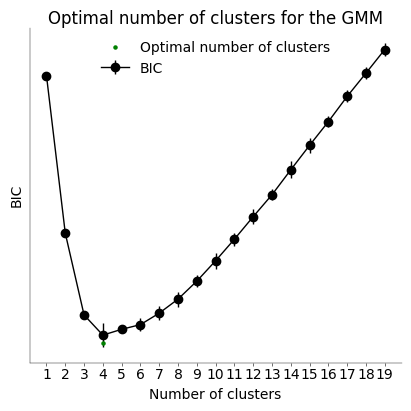

In [25]:
# set the range of possible cluster number
possible_clusters = np.arange(1, 20, 1)
num_seeds = 20

# get the optimal cluster number using BIC
ePhys_cluster_n = get_optimal_cluster_number(
    possible_clusters, num_seeds, ephysData_filtered, bic_mode="sklearn", plot=True
)

# fit the GMM model
ePhys_gmm = GMM(n_components=ePhys_cluster_n, random_state=42).fit(ephysData_filtered)

# get the cluster labels, means and covariances
ePhys_clusters = ePhys_gmm.predict(ephysData_filtered)
ePhys_clusters_means = ePhys_gmm.means_
ePhys_clusters_covariances = ePhys_gmm.covariances_

In [26]:
# transform cluster means and covariances to PCA space for plotting later
ePhys_clusters_means = pca.transform(ePhys_clusters_means)
ePhys_clusters_covariances = [
    pca.components_ @ cov @ pca.components_.T for cov in ePhys_clusters_covariances
]

#### t-SNE

In [27]:
# performing t-SNE on the ePhys data
ePhys_tsne = TSNE(init=pca_ePhys, early_exaggeration=4, random_state=42).fit_transform(
    ephysData_filtered
)

#### Plot PCA-processed data with GMM clusters overlay and the t-SNE plot. Here we use original color labels from the paper

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_24947/1399972507.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_24947/1399972507.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 0.98, 'PCA and tSNE of ePhys data with original labeling')

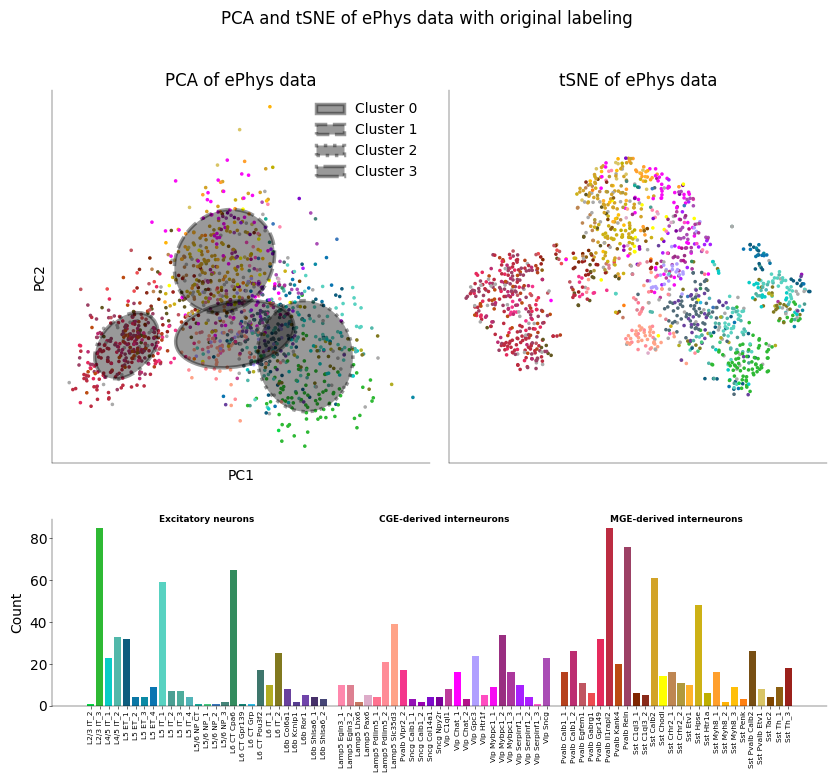

In [28]:
# pca_ePhys = pca_ePhys / np.std(pca_ePhys[:, 0]) * 0.0001

fig = plt.figure(figsize=(10, 8))

gs = GridSpec(2, 2, figure=fig, wspace=0.05, height_ratios=[2, 1])
# Create subplots with the specified gridspec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

plot_PC1_PC2(ax0, pca_ePhys, cluster_colors[keepcells], "PCA of ePhys data")
plot_TSNE(ax1, ePhys_tsne, cluster_colors[keepcells], "tSNE of ePhys data")
plot_cell_types(neuron_groups, ax2, base_font_size=8)

plot_ellipse(
    ePhys_clusters_means,
    ePhys_clusters_covariances,
    ax=ax0,
    color="black",
    cluster_n=ePhys_cluster_n,
)
ax0.legend()
plt.tight_layout()
plt.suptitle("PCA and tSNE of ePhys data with original labeling", fontsize=12)

#### Plot PCA-processed data and the t-SNE plot with GMM cluster labels

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_24947/3501666838.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


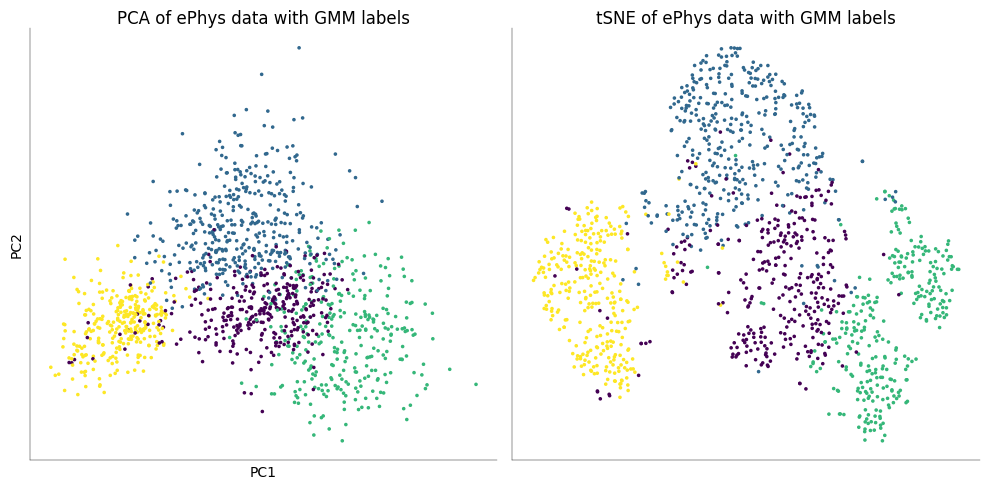

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    pca_ePhys[:, 0],
    pca_ePhys[:, 1],
    s=10,
    c=ePhys_clusters,
    alpha=1,
    zorder=10,
)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].axis = "equal"
ax[0].set_title("PCA of ePhys data with GMM labels")
ax[1].scatter(
    ePhys_tsne[:, 0],
    ePhys_tsne[:, 1],
    s=10,
    c=ePhys_clusters,
    alpha=1,
    zorder=10,
)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].axis = "equal"
ax[1].set_title("tSNE of ePhys data with GMM labels")
plt.tight_layout()

#### We can compare GMM labeling with original lableing

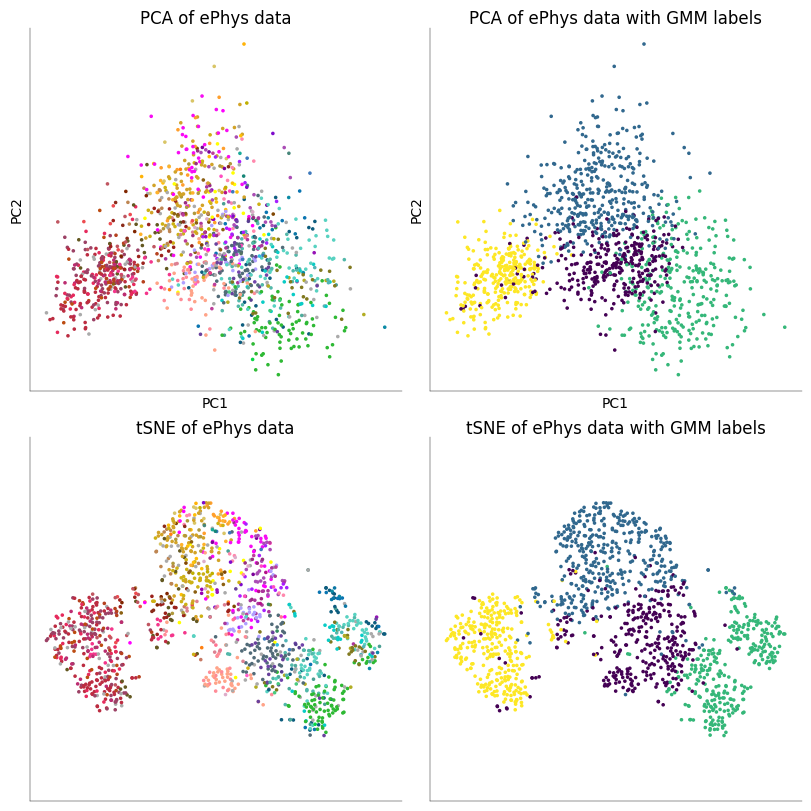

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

plot_PC1_PC2(ax[0, 0], pca_ePhys, cluster_colors[keepcells], "PCA of ePhys data")
plot_PC1_PC2(ax[0, 1], pca_ePhys, ePhys_clusters, "PCA of ePhys data with GMM labels")
plot_TSNE(ax[1, 0], ePhys_tsne, cluster_colors[keepcells], "tSNE of ePhys data")
plot_TSNE(ax[1, 1], ePhys_tsne, ePhys_clusters, "tSNE of ePhys data with GMM labels")

#### Creating K-nearest neighbors graph and Leiden partition for morphological data (Artemii)

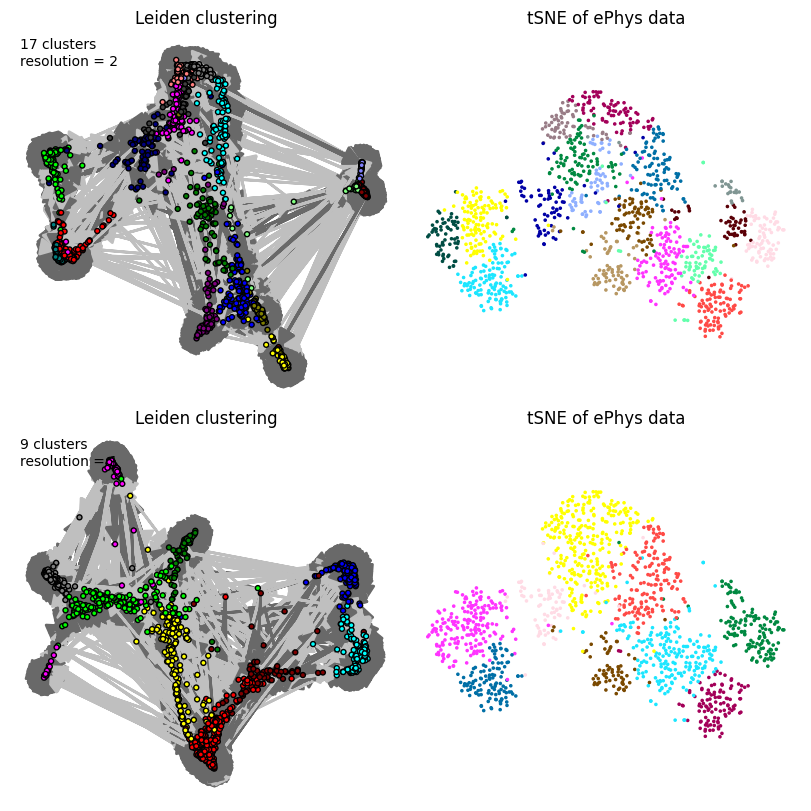

In [56]:
import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]
clusterCols = np.array(clusterCols)

data = ephysData_filtered

A = kneighbors_graph(data, 10, mode="connectivity", include_self=False)
sources, targets = A.nonzero()
G = ig.Graph(directed=True)
G.add_vertices(A.shape[0])
edges = list(zip(sources, targets))
G.add_edges(edges)

resolutions = [2, 1]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    partition = la.find_partition(
        G,
        la.RBConfigurationVertexPartition,
        resolution_parameter=resolutions[i],
        seed=42,
    )

    ig.plot(
        partition,
        vertex_size=5,
        edge_curved=False,
        edgecolor="black",
        colors=clusterCols[partition.membership],
        target=ax[i][0],
    )
    ax[i][0].set_title("Leiden clustering")
    ax[i][0].text(
        0.025,
        0.9,
        f"{len(np.unique(partition.membership))} clusters\nresolution = {resolutions[i]}",
        transform=ax[i][0].transAxes,
    )

    plot_TSNE(
        ax[i][1],
        ePhys_tsne,
        clusterCols[partition.membership],
        "tSNE of ePhys data",
    )

    sns.despine(ax=ax[i][1], left=True, bottom=True)

#### Plot selected electrophysiological features for the cells, clustered by GMM

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_24947/1137455490.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


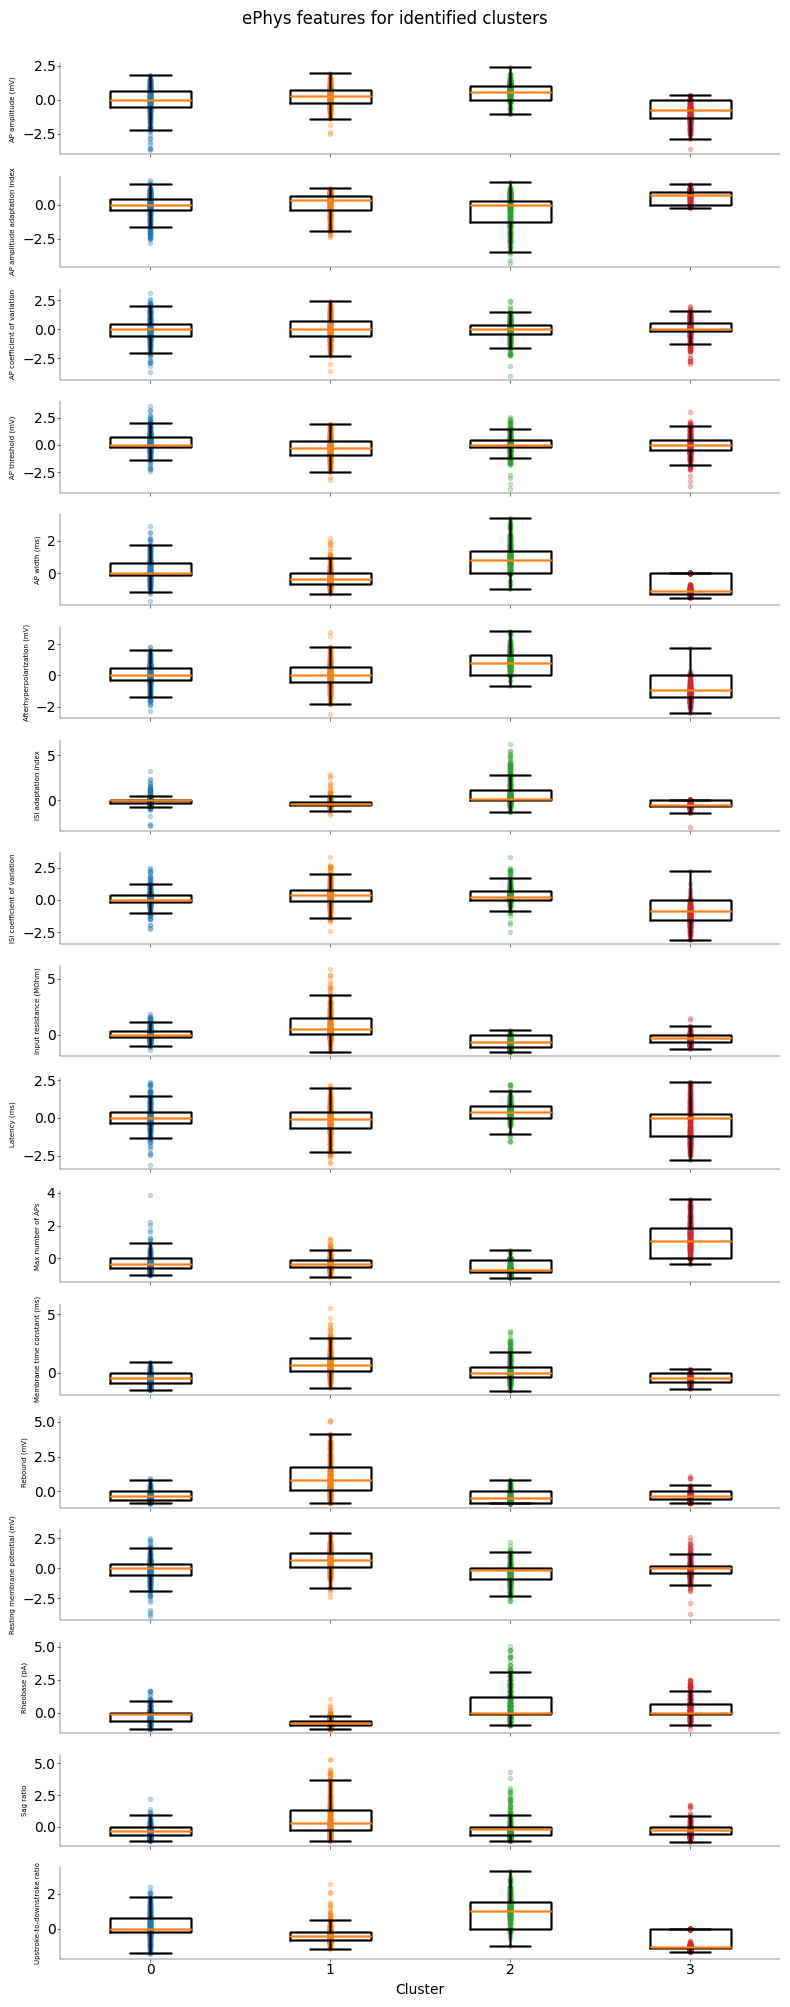

In [32]:
data = ephysData_filtered
features = ephysNames[~np.isin(ephysNames, features_exclude)]
mean_Per_group = np.zeros((len(features), len(np.unique(ePhys_clusters))))
std_Per_group = np.zeros((len(features), len(np.unique(ePhys_clusters))))
for i, c in enumerate(np.unique(ePhys_clusters)):
    mean_Per_group[:, i] = np.mean(data[ePhys_clusters == c, :], axis=0)
    std_Per_group[:, i] = np.std(data[ePhys_clusters == c, :], axis=0)


n_features = features.size
clusters_data = np.zeros((len(features), len(np.unique(ePhys_clusters)), data.shape[0]))

unique_clusters = np.unique(ePhys_clusters)
# Determine the max number of samples in any cluster
max_samples = max(np.sum(ePhys_clusters == c) for c in unique_clusters)

clusters_data = np.zeros((len(features), len(unique_clusters), max_samples))

for i, c in enumerate(unique_clusters):
    cluster_data = data[ePhys_clusters == c, :].T
    clusters_data[:, i, : cluster_data.shape[1]] = cluster_data

fig, ax = plt.subplots(len(features), 1, figsize=(8, 20), sharex=True)
for i, feature in enumerate(features):
    for j, c in enumerate(np.unique(ePhys_clusters)):
        ax[i].scatter(
            np.zeros(clusters_data.shape[2]) + j,
            clusters_data[i, j, :],
            # use the same colors as for gmm clusters
            color=plt.cm.tab10.colors[j],
            alpha=0.25,
        )
        ax[i].boxplot(
            clusters_data[i, :, :].T,
            positions=np.arange(len(np.unique(ePhys_clusters))),
            showfliers=False,
            patch_artist=False,
        )

    ax[i].set_xticks(np.arange(len(np.unique(ePhys_clusters))))
    ax[i].set_xticklabels(np.unique(ePhys_clusters))
    ax[i].set_ylabel(feature, fontsize=5)
    ax[i].set_xlabel("Cluster") if i == len(features) - 1 else None
plt.suptitle("ePhys features for identified clusters", y=1.001)
plt.tight_layout()